amirali aghazadeh + hunter, June 2020

This notebook applies L1 regularization to the WHT coefficients induced by a Neural Network
This method does not scale so if you are looking for that method it's probably in another (possibly future) notebook

In [1]:
import numpy as np
import pickle
import glob
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm
import pandas as pd

from sklearn.metrics import r2_score
#import ipdb #HMN: I didn't have ipdb so I commented this out

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

from scipy.special import comb

from sklearn.metrics import r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from scipy.special import comb
from sklearn import ensemble
from copy import deepcopy

import matplotlib.pyplot as plt
import numpy as np
#import ipdb
import random

import torch
# import torchvision
# import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")

import sys
from utils import *

# Load Protein data and Visualize

Data is from the paper: https://www.nature.com/articles/s41467-019-12130-8

Poelwijk, Frank J., Michael Socolich, and Rama Ranganathan. "Learning the pattern of epistasis linking genotype and phenotype in a protein." Nature communications 10.1 (2019): 1-11.

In [2]:
data = pd.read_excel(open('data/41467_2019_12130_MOESM7_ESM.xlsx', 'rb')) 
data


,binary,amino acid,counts,counts.1,counts.2,Unnamed: 5,brightness,brightness.1,Unnamed: 8,brightness.2
0,genotype,sequence,input,red,blue,NaN,red,blue,NaN,combined
1,'0000000000000',DVLTFNSAAYNNK,5431,12,7846,NaN,0.0853166,1.57463,NaN,1.57463
2,'0000000000001',DVLTFNSAAYNNR,6574,11,9047,NaN,0.0756371,1.54427,NaN,1.54428
3,'0000000000010',DVLTFNSAAYNKK,10493,33,13352,NaN,0.103633,1.49045,NaN,1.49046
4,'0000000000011',DVLTFNSAAYNKR,9545,35,12513,NaN,0.106846,1.51198,NaN,1.51198
...,...,...,...,...,...,...,...,...,...,...
8188,'1111111111011',NAMPSAGCLRNKR,1202,536,13,NaN,0.881762,0.182807,NaN,0.881917
8189,'1111111111100',NAMPSAGCLRDNK,449,69,0,NaN,0.550323,0.239402,NaN,0.553054
8190,'1111111111101',NAMPSAGCLRDNR,1184,228,13,NaN,0.630318,0.190188,NaN,0.630917
8191,'1111111111110',NAMPSAGCLRDKK,612,156,5,NaN,0.690928,0.161936,NaN,0.691138


In [3]:
genotype_list = list(data['binary'])
genotype_list = genotype_list[1:]
brightness_list = list(data['brightness.2'])
brightness_list = brightness_list[1:]

In [4]:
# get rid of extra charactrs in the input, run this only once!
for ind,item in enumerate(genotype_list):
    genotype_list[ind]=item[1:-1]

In [5]:
data_dict = dict(zip(genotype_list, brightness_list ))

In [6]:
L = 13              # length of the protein
N = 2**L            # size of the landscape

In [7]:
# create the landscape
landscape = np.zeros(N)
for ind in range(N):
    code = dec_to_bin(ind,L)
    seq = "".join(str(x) for x in code)
    landscape[ind] = data_dict[seq]

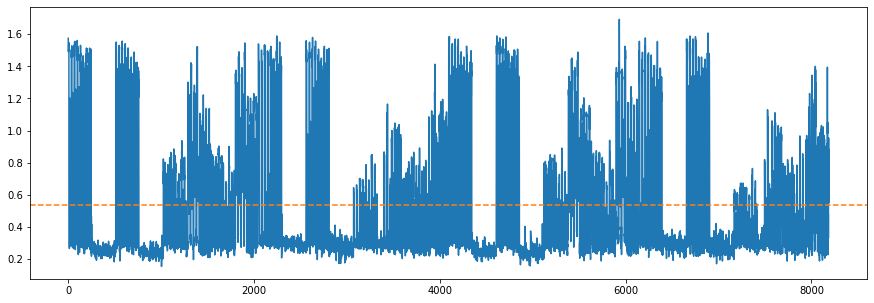

<Figure size 1080x360 with 0 Axes>

In [8]:
# import seaborn as sns
# sns.set_style('dark')
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(landscape)
plt.axhline(np.mean(landscape), color='C1', linestyle='--')
plt.show()
plt.clf()

In [9]:
np.mean(landscape)

0.5380500995194573

In [10]:
landscape_wht = (1/np.sqrt(N)) * myfwht(landscape)

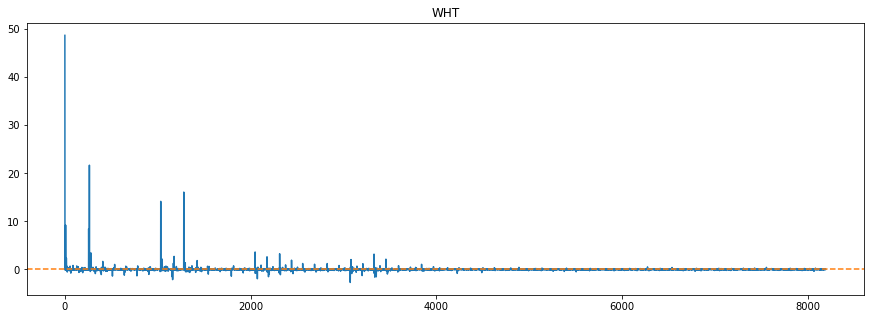

<Figure size 1080x360 with 0 Axes>

In [11]:
plt.plot(landscape_wht)
plt.axhline(np.mean(landscape_wht), color='C1', linestyle='--')
plt.title('WHT')
plt.show()
plt.clf()

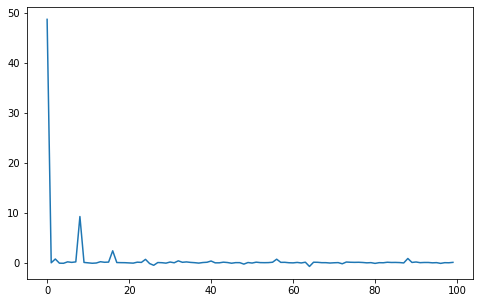

In [12]:
# first 100 WHT coefficients
plt.rcParams['figure.figsize'] = [8, 5]
plt.plot(landscape_wht[0:100])
plt.show()

In [13]:
# sanity check: WHT of WHT is identity operator
landscape_wht_wht = (1/np.sqrt(N)) * myfwht(landscape_wht)


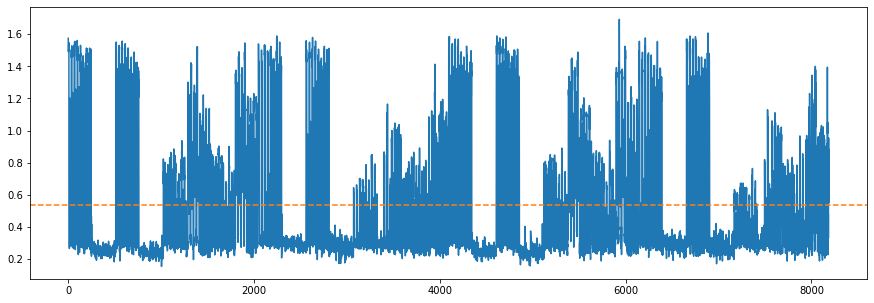

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]
plt.plot(landscape_wht_wht)
plt.axhline(np.mean(landscape_wht_wht), color='C1', linestyle='--')
plt.show()

* How sparse are the WHT coefficients?

In [15]:
landscape_wht_sorted = np.sort(np.abs(landscape_wht))[::-1]

In [16]:
cumulative_energy = np.zeros(N)
total_energy = np.linalg.norm(landscape_wht_sorted)
for ind in range(N):
    cumulative_energy[ind] = np.linalg.norm(landscape_wht_sorted[0:ind]) / total_energy

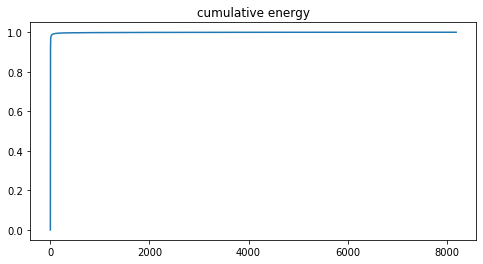

In [17]:
fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.plot(cumulative_energy[0:10000])
plt.title('cumulative energy')
plt.show()

In [18]:
cumulative_energy[40]

0.989050616708871

Using 40 samples (0.4%) we can capture more than 99% of the energy.

In [19]:
class Net(nn.Module):
    def __init__(self, n, multiplier):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(n, multiplier*n)
        self.bn1 = nn.BatchNorm1d(multiplier*n)
        self.fc2 = nn.Linear(multiplier*n, multiplier*n)
        self.bn2 = nn.BatchNorm1d(multiplier*n)
        self.fc3 = nn.Linear(multiplier*n, n)
        self.bn3 = nn.BatchNorm1d(n)
        self.fc4 = nn.Linear(n, 1)
        torch.nn.init.xavier_uniform_(self.fc1.weight)
        torch.nn.init.xavier_uniform_(self.fc2.weight)
        torch.nn.init.xavier_uniform_(self.fc3.weight)
        torch.nn.init.xavier_uniform_(self.fc4.weight)

        # here are going ot define the sizes of the inputs and outputs based off this multiplier 

    def forward(self, x):
        x = self.bn1(F.leaky_relu(self.fc1(x)))
        x = self.bn2(F.leaky_relu(self.fc2(x)))
        x = self.bn3(F.leaky_relu(self.fc3(x)))
        x = self.fc4(x)
        return x
    
def test(net, X, y):    
    with torch.no_grad():
        y_hat = net(torch.from_numpy(X).float())
    e = y - y_hat.numpy().flatten()
    return np.mean(e**2)

## Here is the training code *with* WHT Regularization

In [40]:
def LOOP(data_dict, m, number_of_epochs, random_seed, alpha, use_wht_loss= True):


    '''
    BEGIN: Compute WHT Basis and Set Up Regularization Loss Functions
    '''

    n = 13                    # input code size
    batch_size = m            # neural network batch size 

    number_of_rows = 2**13 ## we are interested in the square matrix
    possible_support =  generate_all_codes(n)
    X_all = np.zeros((number_of_rows,n))

    for ind in range(number_of_rows):
        X_all[ind] = dec_to_bin(ind, n)
    
    M_all = make_system_simple(np.vstack(possible_support), X_all)
    wht_mat = torch.tensor(M_all, dtype=torch.float)
    l1_loss = torch.nn.L1Loss()
    l2_loss = torch.nn.MSELoss()
    num_coeffs = torch.tensor(len(possible_support), dtype=torch.float)
    reg_target = torch.zeros((batch_size, len(possible_support)))

    # create a dataloader that loads all sequences in one batch
    # this might need to be modified to operate in minibatches on GPU
    wht_batch_size = wht_mat.shape[0]
    wht_dataset = torch.utils.data.TensorDataset(torch.from_numpy(X_all).float())
    wht_loader = torch.utils.data.DataLoader(wht_dataset, batch_size=wht_batch_size, shuffle=False)

    '''
    END: Compute WHT Basis and Set Up Regularization Loss Functions
    '''

    random.seed(random_seed)
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)
    
    X_super_set = np.zeros((2**n,n)).astype(int)
    perm = np.random.permutation(2**n)
    for i,ind in enumerate(perm):
        X_super_set[ind] = dec_to_bin(i,n).astype(int)
        
    y_super_set = np.zeros(np.shape(X_super_set)[0])
    for code_itr,code in enumerate(X_super_set):
        seq = "".join(str(x) for x in code)            
        y_super_set[code_itr] = data_dict[seq]
    
    ## train data
    X = X_super_set[0:m,:]
    y = y_super_set[0:m]

    X_train_0 = deepcopy(X)
    y_train_0 = deepcopy(y)
    
    # ## val data for model selection
    X_val = X_super_set[-4000:-3000,:]
    y_val = y_super_set[-4000:-3000]
    
    ## test data -- note that we will use this in the LOOP but it always stays as "test" 
    X_test = X_super_set[-3000:,:]
    y_test = y_super_set[-3000:]

    net = Net(n=n, multiplier=10)
    train = torch.utils.data.TensorDataset(torch.from_numpy(X).float(), torch.from_numpy(y).float())
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)

    ## MSE loss seems reasonable
    criterion = nn.MSELoss(reduction='none')
    optimizer = optim.Adam(net.parameters(), lr=0.01)

    loss_array = []
    loop_id = 0
    
    r2_test_list = []
    r2_train_list = []
    r2_val_list = []
    
        
    pr_test_list = []
    pr_train_list = []
    pr_val_list = []
    


    ebar = tqdm(range(number_of_epochs))
    for epoch in ebar:  # loop over the dataset multiple times
        print(epoch)
        running_loss = 0.0
        batches = 0
        for i, data in enumerate(train_loader, 0):

            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            l1_regularization, l2_regularization = 0, 0
            for param in net.parameters():
                l1_regularization += torch.norm(param, 1)
                l2_regularization += pow(torch.norm(param, 2),2)

            loss = criterion(outputs, labels.unsqueeze(1)) 
            loss = loss.mean() + 0.1 * l2_regularization ## use to be 0.1 * l2
            if use_wht_loss:
                for wht_batch, in wht_loader:
                    wht_out = net(wht_batch).reshape(-1)
                    wht_coeffs = (1/torch.sqrt(num_coeffs))*F.linear(wht_out, wht_mat)
                    loss_wht = l1_loss(wht_coeffs, reg_target)
                print('loss ', loss_wht.item(), loss.item())
                loss += alpha*loss_wht

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            batches += 1
        epoch_loss = running_loss/batches
        loss_array.append(epoch_loss)
        ebar.set_description('loss={0:.2f}'.format(epoch_loss))
        
        net.eval()
        with torch.no_grad():
            y_hat_train = net(torch.from_numpy(X).float())
        y_hat_train = y_hat_train.numpy().flatten()
        
        with torch.no_grad():
            y_hat_test = net(torch.from_numpy(X_test).float())
        y_hat_test = y_hat_test.numpy().flatten()
        
        with torch.no_grad():
            y_hat_val = net(torch.from_numpy(X_val).float())
        y_hat_val = y_hat_val.numpy().flatten()
        
        r2_test_list.append(r2_score(y_test,y_hat_test))
        r2_train_list.append(r2_score(y,y_hat_train))
        r2_val_list.append(r2_score(y_val,y_hat_val))
    
        
        pr_test_list.append(pearsonr(y_test,y_hat_test)[0])
        pr_train_list.append(pearsonr(y,y_hat_train)[0])
        pr_val_list.append(pearsonr(y_val,y_hat_val)[0])
        
        net.train()
        
        print('val R^2', r2_score(y_val,y_hat_val))
        print('-')
        

    r2valind = np.argmax(r2_val_list)
    prvalind = np.argmax(pr_val_list)
    
    return r2_test_list[r2valind],r2_train_list[r2valind],pr_test_list[prvalind],pr_train_list[prvalind]

    


In [42]:
r2_test,r2_tr,pr_test,pr_tr = LOOP(data_dict, m=60, number_of_epochs=160, random_seed=0, alpha = 0.1, use_wht_loss=True)
print('test R2, train R2',r2_test,r2_tr)

0
loss  0.6316893696784973 48.514286041259766
val R^2 -2.7627655480563815
-
1
loss  0.48695164918899536 46.42112350463867
val R^2 -2.4825849099450465
-
2
loss  0.38247552514076233 43.863555908203125
val R^2 -1.9086195485857722
-
3
loss  0.32256603240966797 42.12611770629883
val R^2 -1.435670526550322
-
4
loss  0.2873746156692505 40.461544036865234
val R^2 -1.0729742949335934
-
5
loss  0.2651688754558563 38.80281066894531
val R^2 -0.8061321437911546
-
6
loss  0.24972130358219147 37.15633010864258
val R^2 -0.6026584810693276
-
7
loss  0.23814824223518372 35.538578033447266
val R^2 -0.44755135680355185
-
8
loss  0.22869352996349335 33.97043228149414
val R^2 -0.3272043938534819
-
9
loss  0.22083845734596252 32.4732666015625
val R^2 -0.23611019165756408
-
10
loss  0.2148609459400177 31.054039001464844
val R^2 -0.17129884880202595
-
11
loss  0.2104487270116806 29.71518325805664
val R^2 -0.13140919443715515
-
12
loss  0.2071862369775772 28.46002960205078
val R^2 -0.11396518349157692
-
13
loss

loss  0.04701881483197212 1.2524876594543457
val R^2 0.052430899631642824
-
108
loss  0.04725094139575958 1.221925139427185
val R^2 0.49393707664677244
-
109
loss  0.046002402901649475 1.1907200813293457
val R^2 0.6303853428579007
-
110
loss  0.046680618077516556 1.1614313125610352
val R^2 0.6734780874444739
-
111
loss  0.045925479382276535 1.13080894947052
val R^2 0.7136348245919008
-
112
loss  0.04396354407072067 1.0981087684631348
val R^2 0.7155141401728631
-
113
loss  0.04317377135157585 1.0624676942825317
val R^2 0.6935260206284055
-
114
loss  0.042658865451812744 1.0238198041915894
val R^2 0.6900635227817199
-
115
loss  0.04155491665005684 0.9839967489242554
val R^2 0.696396947339618
-
116
loss  0.04002879559993744 0.9432085752487183
val R^2 0.6621983888832319
-
117
loss  0.038243576884269714 0.9020766019821167
val R^2 0.6131077474148039
-
118
loss  0.036320701241493225 0.8614974021911621
val R^2 0.5276245034938736
-
119
loss  0.0355333611369133 0.8216294646263123
val R^2 0.49204